<a href="https://colab.research.google.com/github/Tahiea/Personal-Projects/blob/main/Dengue_Forecast_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Forecasting Dengue

Dataset link: https://github.com/Tahiea/Personal-Projects/blob/main/Dengue%20Data%20BD.xlsx

Dataset description:
The dataset contains the following data from 2008 to 2025 May.
Month, Average Rainfall (mm), Average Temperature (°C),
Average Rel. Humidity (%), Total Cases, Number of Deaths

We are going to use SARIMAX and later ML models to predict total cases and deaths from Denue. We are using SARIMAX because we want to include rainfall, humidity and temperature data as exogenous variables.



# Importing relevant libraries

In [ ]:
!pip install numpy==1.26.4
!pip install --no-cache-dir pmdarima


In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pmdarima import auto_arima
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Importing data and preprocessing

In [ ]:
data_raw = pd.read_excel('Dengue Data BD.xlsx')

In [ ]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      209 non-null    int64  
 1   Month     209 non-null    int64  
 2   Rainfall  209 non-null    float64
 3   Temp      209 non-null    float64
 4   Hum       209 non-null    float64
 5   Tot_case  209 non-null    int64  
 6   Death     209 non-null    int64  
dtypes: float64(3), int64(4)
memory usage: 11.6 KB


In [ ]:
data_raw.head()

,Year,Month,Rainfall,Temp,Hum,Tot_case,Death
0,2025,1,8.0,18.5,79.6,1161,10
1,2025,2,25.0,22.0,64.8,374,3
2,2025,3,75.0,27.0,62.7,336,0
3,2025,4,130.0,28.5,68.2,701,7
4,2025,5,250.0,29.5,72.7,1730,3


In [ ]:
#data = data_raw.iloc[:, :5]
data = data_raw.copy()

In [ ]:
data.head()

,Year,Month,Rainfall,Temp,Hum,Tot_case,Death
0,2025,1,8.0,18.5,79.6,1161,10
1,2025,2,25.0,22.0,64.8,374,3
2,2025,3,75.0,27.0,62.7,336,0
3,2025,4,130.0,28.5,68.2,701,7
4,2025,5,250.0,29.5,72.7,1730,3


In [ ]:
data.isnull().sum()

,0
Year,0
Month,0
Rainfall,0
Temp,0
Hum,0
Tot_case,0
Death,0


In [ ]:
#data preprocessing
#synthetically producing a date column from the Year and Month column in the dataset
data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))

# we are going to perform timeseries calculation on the dataset - so we are
# converting the date to Index.
data = data.set_index('Date')


In [ ]:
data.head()

,Year,Month,Rainfall,Temp,Hum,Tot_case,Death
Date,,,,,,,
2025-01-01,2025,1,8.0,18.5,79.6,1161,10
2025-02-01,2025,2,25.0,22.0,64.8,374,3
2025-03-01,2025,3,75.0,27.0,62.7,336,0
2025-04-01,2025,4,130.0,28.5,68.2,701,7
2025-05-01,2025,5,250.0,29.5,72.7,1730,3


In [ ]:
data = data.sort_index()

#EDA

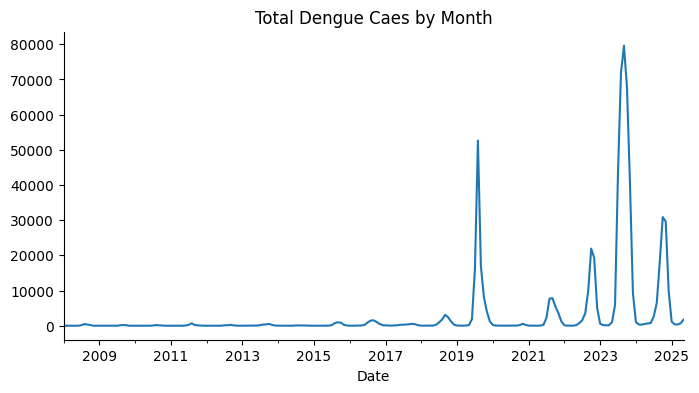

In [ ]:
from matplotlib import pyplot as plt
data['Tot_case'].plot(kind='line', figsize=(8, 4), title='Total Dengue Caes by Month')
plt.gca().spines[['top', 'right']].set_visible(False)

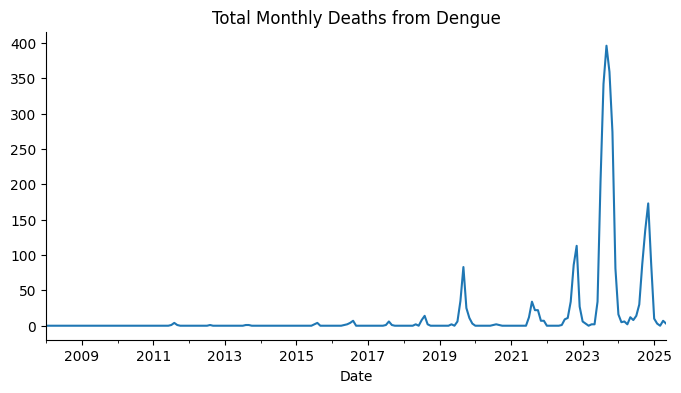

In [ ]:
from matplotlib import pyplot as plt
data['Death'].plot(kind='line', figsize=(8, 4), title='Total Monthly Deaths from Dengue')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
data.tail(25)


,Year,Month,Rainfall,Temp,Hum,Tot_case,Death
Date,,,,,,,
2023-05-01,2023,5,250.0,29.5,72.7,1036,2
2023-06-01,2023,6,400.0,29.0,73.6,5956,34
2023-07-01,2023,7,450.0,28.5,81.8,43854,204
2023-08-01,2023,8,400.0,28.5,79.5,71976,342
2023-09-01,2023,9,300.0,28.0,82.9,79598,396
2023-10-01,2023,10,150.0,27.0,78.5,67769,359
2023-11-01,2023,11,20.0,24.0,76.6,40716,274
2023-12-01,2023,12,10.0,20.0,78.1,9288,81
2024-01-01,2024,1,8.0,19.0,79.6,1055,16


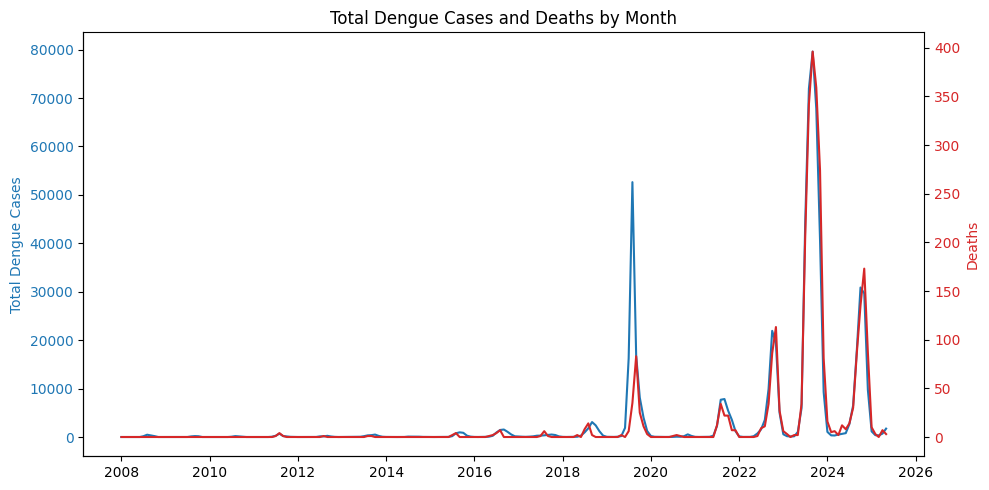

In [ ]:
## putting the Total Dengue cases and Deaths in one chart

from matplotlib import pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Tot_case on primary y-axis
ax1.plot(data.index, data['Tot_case'], color='tab:blue', label='Total Cases')
ax1.set_ylabel('Total Dengue Cases', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Remove top/right spines
ax1.spines[['top', 'right']].set_visible(False)

# Plot Death on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(data.index, data['Death'], color='tab:red', label='Deaths')
ax2.set_ylabel('Deaths', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and layout
plt.title('Total Dengue Cases and Deaths by Month')
fig.tight_layout()
plt.show()


In [ ]:
data.describe()


,Year,Month,Rainfall,Temp,Hum,Tot_case,Death
count,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000
mean,2016.215311,6.416268,184.558373,25.747512,75.137560,3103.157895,13.961722
std,5.043708,3.467420,185.905453,4.312365,13.166518,10900.955881,53.051938
min,2008.000000,1.000000,0.000000,14.700000,42.940000,0.000000,0.000000
25%,2012.000000,3.000000,21.090000,22.030000,65.440000,9.000000,0.000000
50%,2016.000000,6.000000,130.000000,27.840000,78.690000,111.000000,0.000000
75%,2021.000000,9.000000,300.000000,28.620000,86.690000,644.000000,2.000000
max,2025.000000,12.000000,875.390000,33.010000,91.500000,79598.000000,396.000000


# SARIMAX

In [ ]:
#AUTO Tuning the seasonal orders -
##ARIMA orders: (p,d,q)(p,d,q)
##Seasonal orders: (P,D,Q,s)(P,D,Q,s)


# We have a seasonal time series with datetime index
auto_model = auto_arima(
    data['Tot_case'],
    exogenous=data[['Rainfall', 'Temp', 'Hum']],  # We have three exogenous data
    seasonal=True,
    m=12,                      # Monthly seasonality
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    d=None, D=None,           # Let it infer differencing
    trace=True,               # Show progress
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True             # Fast search
)

# Print best model summary
print(auto_model.summary())

# Get order and seasonal_order for use in SARIMAX
print("Best (p,d,q):", auto_model.order)
print("Best (P,D,Q,s):", auto_model.seasonal_order)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4237.743, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4210.558, Time=0.18 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4207.281, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4235.746, Time=0.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=4207.739, Time=0.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=4205.261, Time=1.44 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=4206.659, Time=0.41 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=4206.542, Time=3.73 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=4206.685, Time=3.87 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=4205.701, Time=1.88 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=4204.556, Time=1.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=4228.476, Time=1.46 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=4206.225, Time=2.50 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(2,0,0)[12] intercept   : AIC=4207.346, Time=1.44 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=4207.622, Time=1.10 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=inf, Time=5.80 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,0,0)[12]             : AIC=4202.557, Time=0.32 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=4204.660, Time=0.15 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,0,1)[12]             : AIC=4204.542, Time=0.76 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,1)[12]             : AIC=4203.260, Time=0.35 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,0,0)[12]             : AIC=4227.317, Time=0.25 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,0)[12]             : AIC=4204.226, Time=0.55 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(2,0,0)[12]             : AIC=4205.346, Time=0.43 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,0)[12]             : AIC=4205.622, Time=0.33 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(2,0,0)[12]             : AIC=inf, Time=1.10 sec

Best model:  ARIMA(0,1,1)(2,0,0)[12]          
Total fit time: 29.863 seconds
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  209
Model:             SARIMAX(0, 1, 1)x(2, 0, [], 12)   Log Likelihood               -2097.278
Date:                             Sun, 20 Jul 2025   AIC                           4202.557
Time:                                     16:55:18   BIC                           4215.907
Sample:                                 01-01-2008   HQIC                          4207.955
                                      - 05-01-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


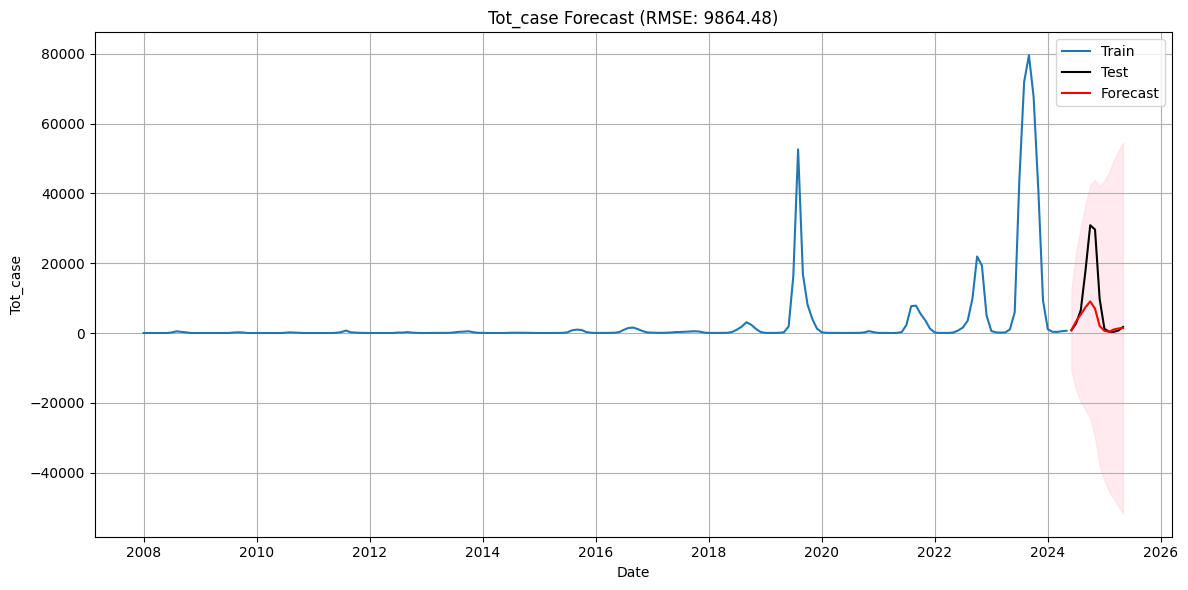

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


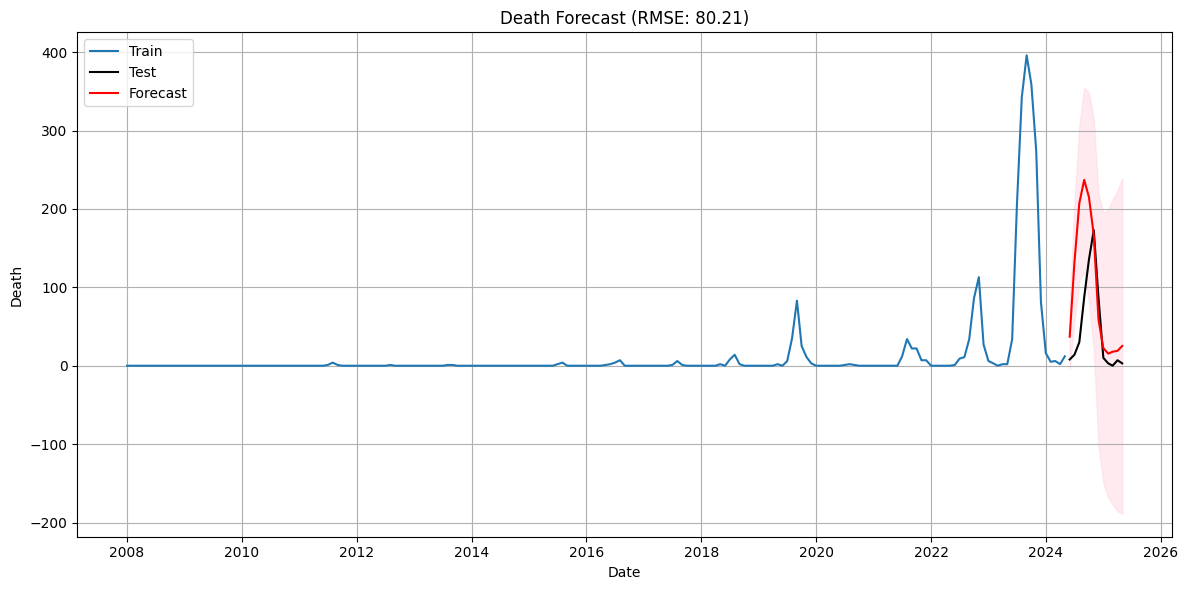

In [ ]:
# Define exogenous variables and forecast horizon
exog_features = ['Rainfall', 'Temp', 'Hum']
forecast_horizon = 12  # Monthly

# Split the data into train and test sets
train = data.iloc[:-forecast_horizon]
test = data.iloc[-forecast_horizon:]

# SARIMAX Forecast Function
def forecast_sarimax(target_column):
    # Fit SARIMAX model
    model = SARIMAX(
        train[target_column],
        exog=train[exog_features],
        order=(0, 1, 1),
        seasonal_order=(2, 0, 0, 12), ## The orders here are from the auto-model summary
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    results = model.fit(disp=False)

    # Forecast
    forecast = results.get_forecast(steps=forecast_horizon, exog=test[exog_features])
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()

    # RMSE Evaluation
    rmse = np.sqrt(mean_squared_error(test[target_column], forecast_mean))
    mae = mean_absolute_error(test[target_column], forecast_mean)

    # Align forecast index for plotting
    forecast_index = test.index
    forecast_mean.index = forecast_index
    forecast_ci.index = forecast_index
    lower = forecast_ci.iloc[:, 0]
    upper = forecast_ci.iloc[:, 1]

    # Plot forecast with confidence intervals
    plt.figure(figsize=(12, 6))
    plt.plot(train[target_column], label="Train")
    plt.plot(test[target_column], label="Test", color='black')
    plt.plot(forecast_mean, label="Forecast", color="red")
    plt.fill_between(forecast_index, lower, upper, color='pink', alpha=0.3)
    plt.title(f"{target_column} Forecast (RMSE: {rmse:.2f})")
    plt.ylabel(target_column)
    plt.xlabel("Date")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Create forecast dataframe
    forecast_df = pd.DataFrame({
        f'Forecast_{target_column}': forecast_mean,
        f'Actual_{target_column}': test[target_column],
        f'Forecast_CI_Lower': lower,
        f'Forecast_CI_Upper': upper
    }, index=forecast_index)

    return forecast_df, rmse, mae

# Forecasting for 'Tot_case'
forecast_tot_case, rmse_sarimax_cases, mae_sarimax_cases = forecast_sarimax('Tot_case')

# Forecasting for 'Death'
forecast_death, rmse_sarimax_deaths, mae_sarimax_deaths = forecast_sarimax('Death')

# Preparing data for all models

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Shift lag-1 for supervised ML
data_ml = data.copy()
data_ml['Prev_cases'] = data_ml['Tot_case'].shift(1)
data_ml['Prev_deaths'] = data_ml['Death'].shift(1)
data_ml.dropna(inplace=True)

# Feature sets
features_case = ['Prev_cases', 'Rainfall', 'Temp', 'Hum']
features_death = ['Prev_deaths', 'Rainfall', 'Temp', 'Hum']

# Targets
target_case = 'Tot_case'
target_death = 'Death'

# Scaling
scaler_case = StandardScaler()
X_case = scaler_case.fit_transform(data_ml[features_case])
y_case = data_ml[target_case]

scaler_death = StandardScaler()
X_death = scaler_death.fit_transform(data_ml[features_death])
y_death = data_ml[target_death]

# Split
forecast_horizon = 12
X_train_case, X_test_case, y_train_case, y_test_case = train_test_split(X_case, y_case, test_size=forecast_horizon, shuffle=False)
X_train_death, X_test_death, y_train_death, y_test_death = train_test_split(X_death, y_death, test_size=forecast_horizon, shuffle=False)

forecast_index = data_ml.index[-forecast_horizon:]


# SVR and GM
# Forecast and Plot Functions

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

def forecast_ml_model(model, model_name, X_train, y_train, X_test, y_test, test_index, target_column):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluation
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    # Align forecast to index
    forecast_series = pd.Series(y_pred, index=test_index)
    actual_series = pd.Series(y_test.values, index=test_index)



    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(train[target_column], label="Train")
    plt.plot(test[target_column], label="Test", color='black')
    plt.plot(test_index, forecast_series, label="Forecast", color="red")
    plt.title(f"{model_name} {target_column} Forecast (RMSE: {rmse:.2f})")
    plt.ylabel(target_column)
    plt.xlabel("Date")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    forecast_df = pd.DataFrame({
        f'Forecast_{target_column}': forecast_series,
        f'Actual_{target_column}': actual_series
    }, index=test_index)

    return forecast_df, rmse, mae

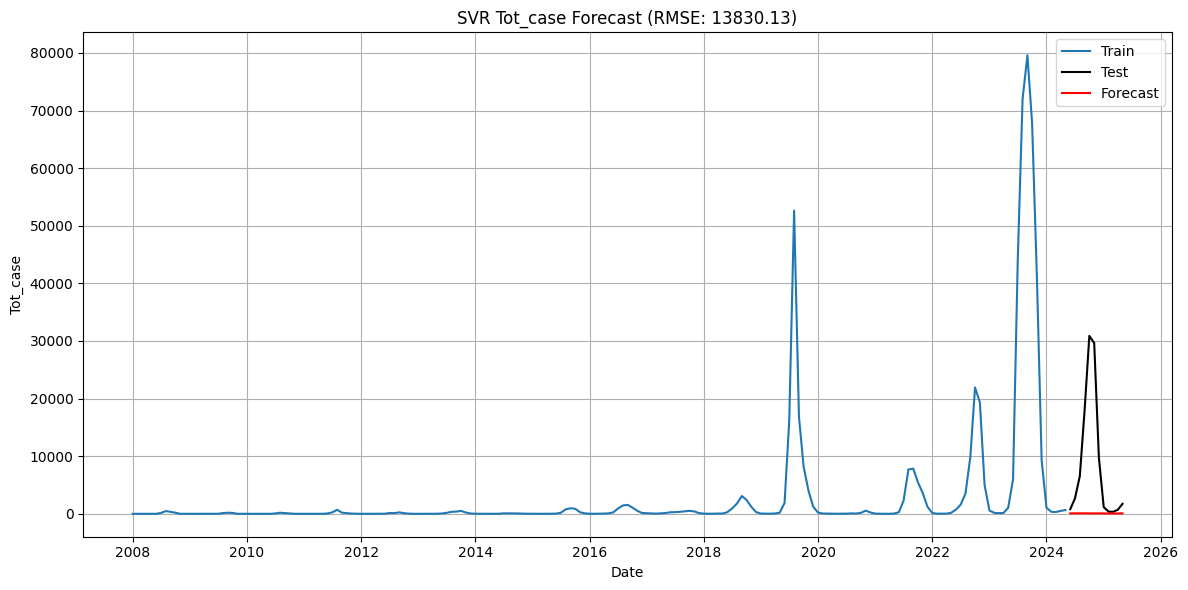

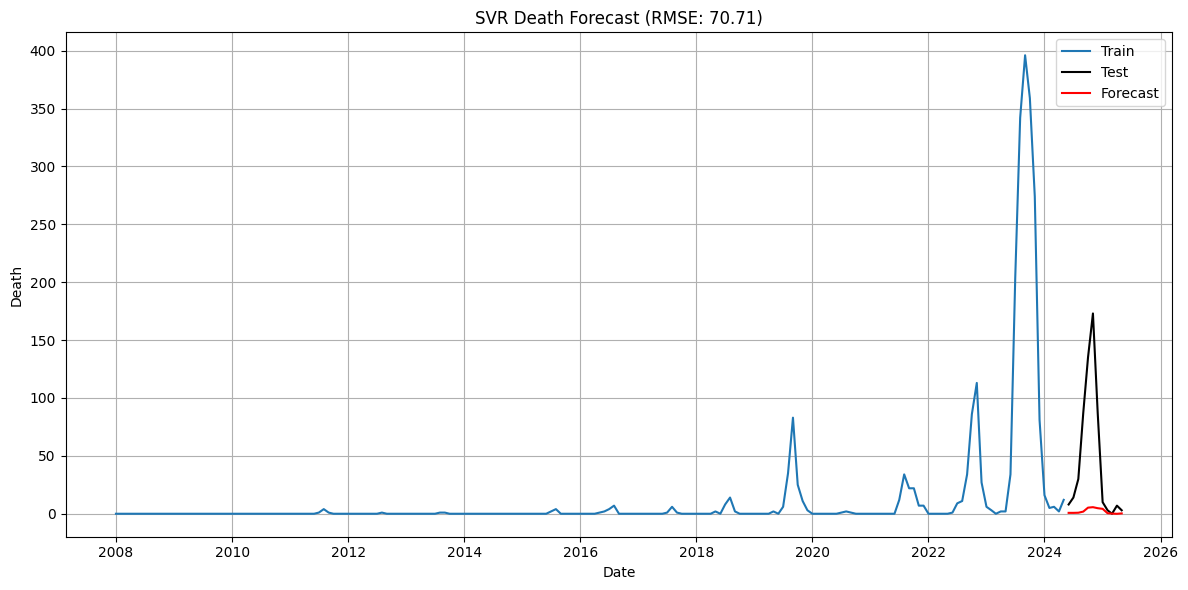

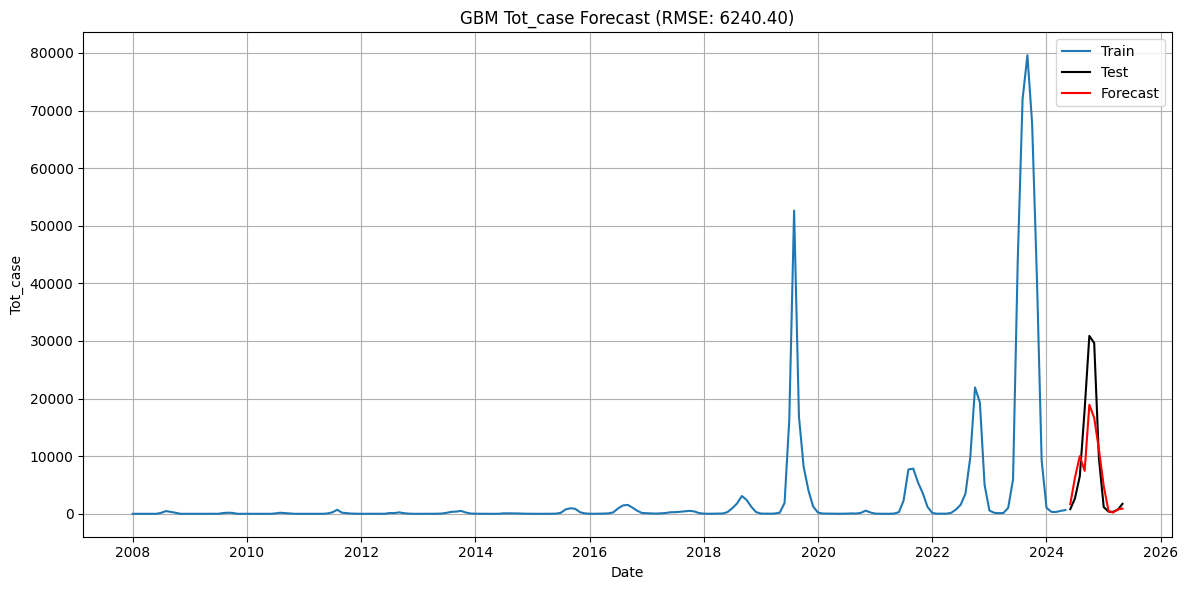

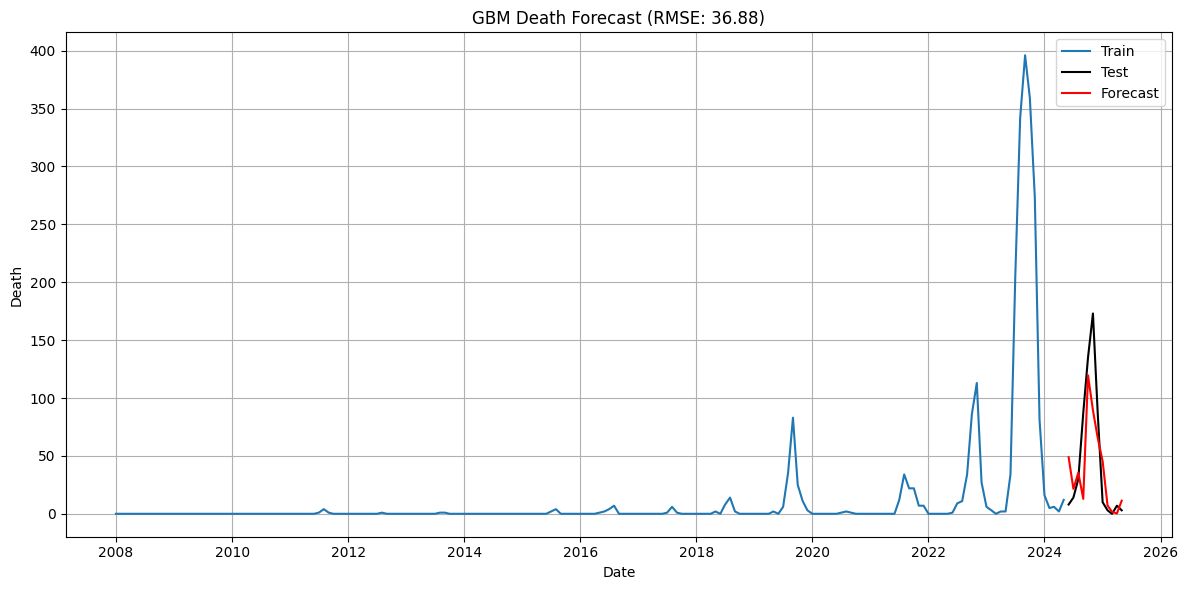

In [ ]:
##Applying the forecast functions on to SVR and GM

from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

# SVR Forecast
forecast_svr_case, rmse_svr_case, mae_svr_case = forecast_ml_model(SVR(), "SVR", X_train_case, y_train_case, X_test_case, y_test_case, forecast_index, 'Tot_case')
forecast_svr_death, rmse_svr_death, mae_svr_death = forecast_ml_model(SVR(), "SVR", X_train_death, y_train_death, X_test_death, y_test_death, forecast_index, 'Death')

# GBM Forecast
forecast_gbm_case, rmse_gbm_case, mae_gbm_case = forecast_ml_model(GradientBoostingRegressor(), "GBM", X_train_case, y_train_case, X_test_case, y_test_case, forecast_index, 'Tot_case')
forecast_gbm_death, rmse_gbm_death, mae_gbm_death = forecast_ml_model(GradientBoostingRegressor(), "GBM", X_train_death, y_train_death, X_test_death, y_test_death, forecast_index, 'Death')


# RMSE AND MAE PLOTS

# LSTM

In [ ]:
from sklearn.preprocessing import MinMaxScaler

#Scale features

scaler_X_case = MinMaxScaler()
scaler_X_death = MinMaxScaler()
X_case_scaled = scaler_X_case.fit_transform(X_case)
X_death_scaled = scaler_X_death.fit_transform(X_death)


#Scale targets
scaler_y_case = MinMaxScaler()
y_case_scaled = scaler_y_case.fit_transform(y_case.values.reshape(-1, 1))
scaler_y_death = MinMaxScaler()
y_death_scaled = scaler_y_death.fit_transform(y_death.values.reshape(-1, 1))

In [ ]:
##sequence generator and data preparation
def create_sequences(X, y, seq_length=12):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:i+seq_length])
        ys.append(y[i+seq_length])
    return np.array(Xs), np.array(ys)

seq_len = 12
X_seq_case, y_seq_case = create_sequences(X_case_scaled, y_case_scaled, seq_len)
X_seq_death, y_seq_death = create_sequences(X_death_scaled, y_death_scaled, seq_len)

X_train_case_lstm, X_test_case_lstm = X_seq_case[:-forecast_horizon], X_seq_case[-forecast_horizon:]
y_train_case_lstm, y_test_case_lstm = y_seq_case[:-forecast_horizon], y_seq_case[-forecast_horizon:]

X_train_death_lstm, X_test_death_lstm = X_seq_death[:-forecast_horizon], X_seq_death[-forecast_horizon:]
y_train_death_lstm, y_test_death_lstm = y_seq_death[:-forecast_horizon], y_seq_death[-forecast_horizon:]


In [ ]:
##Forecast model LSTM

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.optimizers import Adam




def forecast_lstm_model(X_train, y_train, X_test, y_test, test_index, target_column, scaler_y):
    model = Sequential([
        LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        Dense(32),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=100, batch_size=8,
              validation_split=0.2, callbacks=[early_stop], verbose=0)

    # Forecast
    y_pred_scaled = model.predict(X_test).flatten()
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

    # Evaluation
    rmse = mean_squared_error(y_test_inv, y_pred)
    mae = mean_absolute_error(y_test_inv, y_pred)

    # Plot
    forecast_series = pd.Series(y_pred, index=test_index)
    actual_series = pd.Series(y_test_inv, index=test_index)

    plt.figure(figsize=(12, 6))
    plt.plot(train[target_column], label="Train")
    plt.plot(test[target_column], label="Test", color='black')
    plt.plot(test_index, forecast_series, label="Forecast", color="red")
    plt.title(f"LSTM {target_column} Forecast (RMSE: {rmse:.2f}, MAE: {mae:.2f})")
    plt.ylabel(target_column)
    plt.xlabel("Date")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return forecast_series, rmse, mae


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


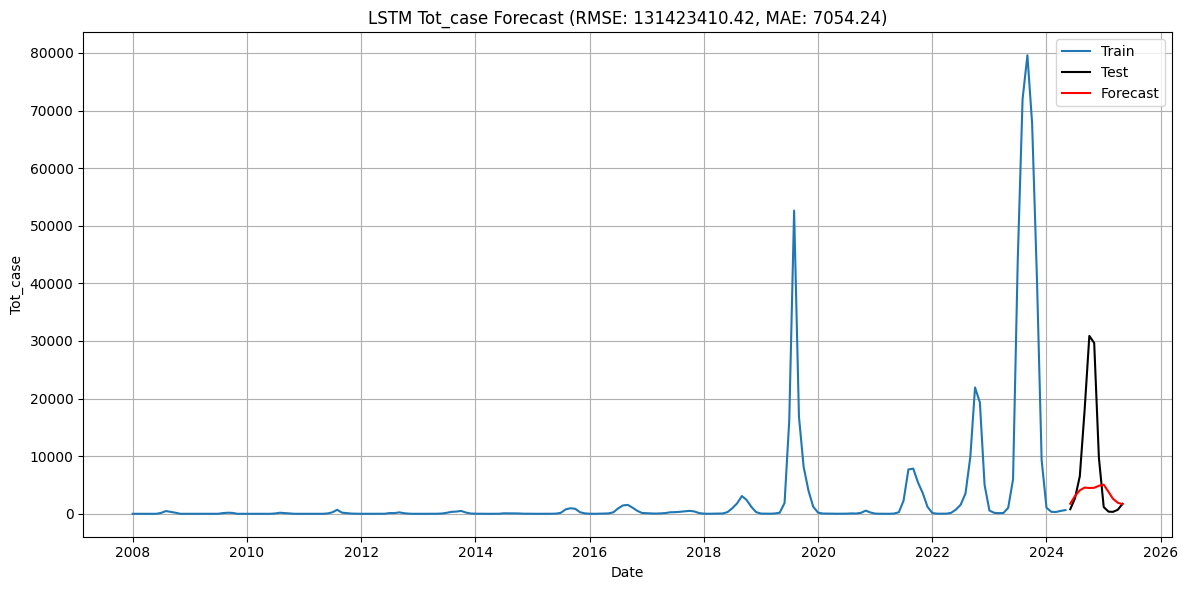

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


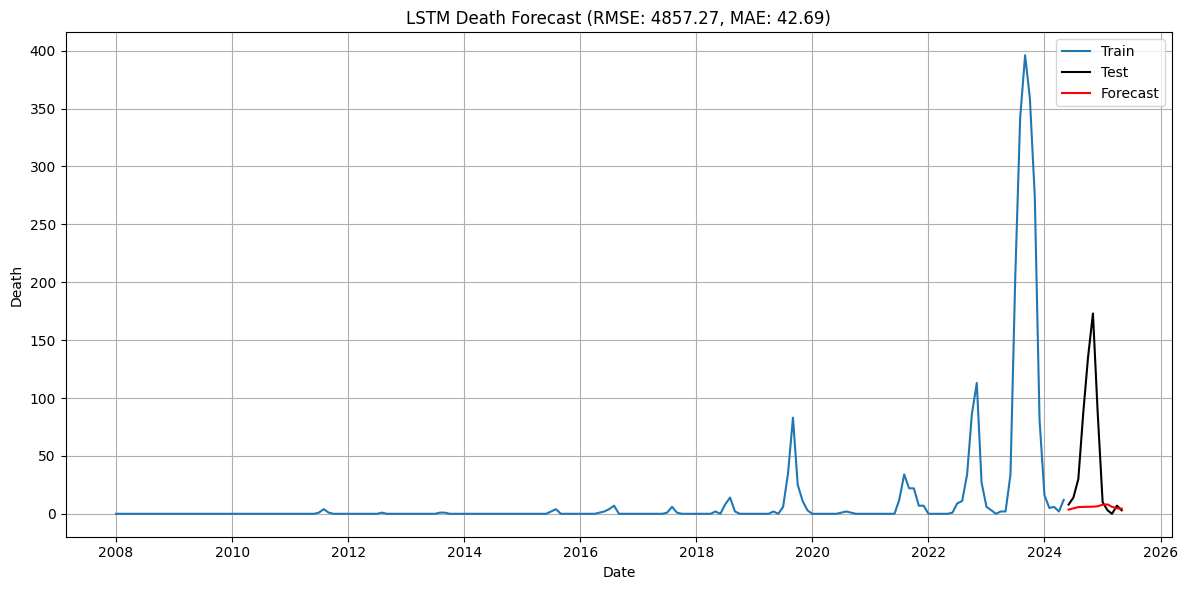

In [ ]:
#Running LSTM
forecast_lstm_case, rmse_lstm_case, mae_lstm_case = forecast_lstm_model(
    X_train_case_lstm, y_train_case_lstm,
    X_test_case_lstm, y_test_case_lstm,
    forecast_index, 'Tot_case', scaler_y_case)

forecast_lstm_death, rmse_lstm_death, mae_lstm_death = forecast_lstm_model(
    X_train_death_lstm, y_train_death_lstm,
    X_test_death_lstm, y_test_death_lstm,
    forecast_index, 'Death', scaler_y_death)



# All Model Comparisons

In [ ]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': ['SARIMAX', 'SVR', 'GBM', 'LSTM'],
    'RMSE_Tot_case': [rmse_sarimax_cases, rmse_svr_case, rmse_gbm_case, rmse_lstm_case],
    'MAE_Tot_case': [mae_sarimax_cases, mae_svr_case, mae_gbm_case, mae_lstm_case],
    'RMSE_Death': [rmse_sarimax_deaths, rmse_svr_death, rmse_gbm_death, rmse_lstm_death],
    'MAE_Death': [mae_sarimax_deaths, mae_svr_death, mae_gbm_death, mae_lstm_death]
})

# Display table
print(comparison_df)


     Model  RMSE_Tot_case  MAE_Tot_case   RMSE_Death  MAE_Death
0  SARIMAX   9.864476e+03   5578.727602    80.206340  55.475038
1      SVR   1.383013e+04   8486.234318    70.714157  44.348315
2      GBM   6.240396e+03   4149.500983    36.882583  25.390271
3     LSTM   1.314234e+08   7054.241018  4857.273371  42.688235


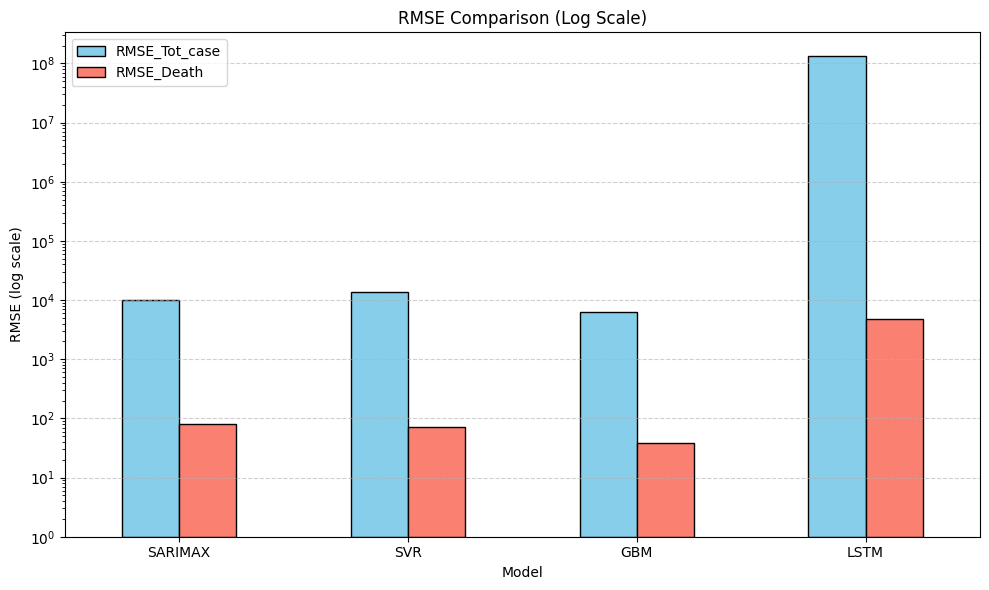

In [ ]:
comparison_df.set_index("Model")[["RMSE_Tot_case", "RMSE_Death"]].plot(
    kind="bar", figsize=(10, 6), log=True, color=["skyblue", "salmon"], edgecolor='black')
plt.title("RMSE Comparison (Log Scale)")
plt.ylabel("RMSE (log scale)")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



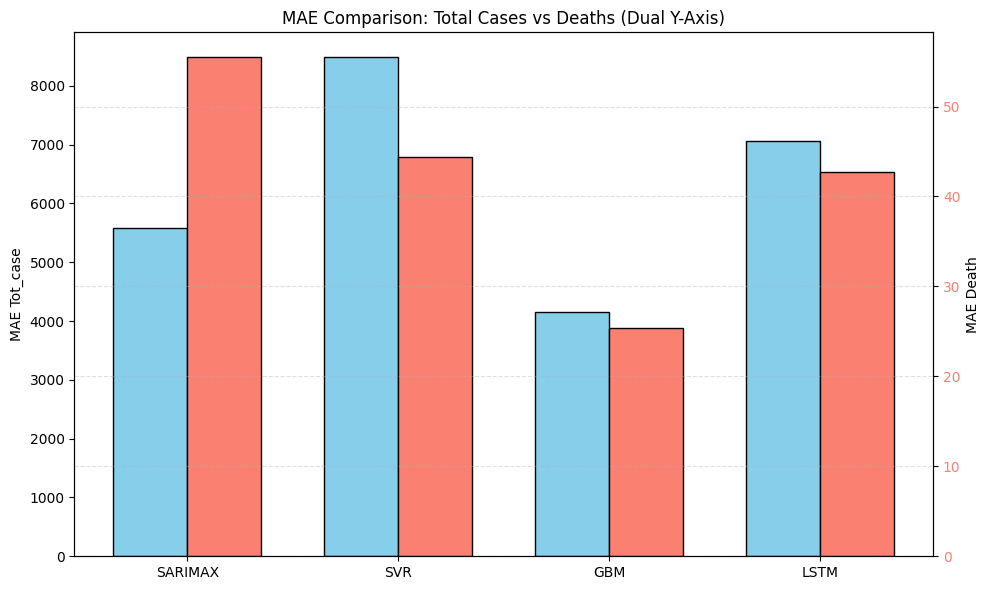

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(comparison_df))  # Number of models
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot MAE_Tot_case on left y-axis
bar1 = ax1.bar(x - width/2, comparison_df['MAE_Tot_case'], width, label='MAE Tot_case', color='skyblue', edgecolor='black')
ax1.set_ylabel('MAE Tot_case')
ax1.set_xticks(x)
ax1.set_xticklabels(comparison_df['Model'])
ax1.tick_params(axis='y')

# Plot MAE_Death on right y-axis
ax2 = ax1.twinx()
bar2 = ax2.bar(x + width/2, comparison_df['MAE_Death'], width, label='MAE Death', color='salmon', edgecolor='black')
ax2.set_ylabel('MAE Death')
ax2.tick_params(axis='y', labelcolor='salmon')

# Title and layout
plt.title('MAE Comparison: Total Cases vs Deaths (Dual Y-Axis)')
fig.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

